In [ ]:

import os
import random
import glob
from shutil import copyfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import pathlib
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/foodss/'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/foodss/
/content/gdrive/My Drive/foodss


In [ ]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=sys.maxsize)
#Instructing Jupyter notebook to use GPU when running ResNet50

# from tensorflow.python.compiler.mlcompute import mlcompute
# mlcompute.set_mlc_device(device_name='gpu')
print("TensorFlow version:", tf.__version__)
print("Is GPU available?", tf.config.list_physical_devices('GPU'))

# As ResNet requires special pre-processing of images, we will also import the necessary input
from tensorflow.keras.applications.resnet import preprocess_input
# Parameters
img_width, img_height = 224, 224
train_data_dir = '../foodss/Final/Training'
validation_data_dir = '../foodss/Final/Validation'
batch_size = 32

TensorFlow version: 2.15.0
Is GPU available? [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Data augmentation our 12,000 training images
train_datagen = keras.preprocessing.image.ImageDataGenerator(
                 rotation_range=20,
                 width_shift_range=0.1,
                 height_shift_range=0.1,
                 shear_range=0.1,
                 zoom_range=0.1,
                 fill_mode='nearest',
                 horizontal_flip=True,
                 preprocessing_function=preprocess_input)

# Data augmentation our 2,400 validation images (note: only rescale for these images)
val_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input)

# Function that reads images from our designated training path and augmenting the images
# within as per our data augementation parameters above
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Function that reads images from our designated validation path and augmenting the images
# within as per our data augementation parameters above
validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Map index to class names
classes = dict((v, k.replace('_', ' ').title()) for k, v in train_generator.class_indices.items())

Found 12859 images belonging to 20 classes.
Found 2584 images belonging to 20 classes.


In [ ]:
# Build the model
base_model = keras.applications.VGG16(
    input_shape=(img_width, img_height, 3),
    include_top=False,
    weights='imagenet')
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import TopKCategoricalAccuracy

In [ ]:

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(20, activation="softmax", kernel_initializer='he_normal', kernel_regularizer=l2())
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=3)]
)

# Early stopping callback
callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='auto',
    restore_best_weights=True)

# Fit the model with the correct method
history = model.fit(
    train_generator,
    epochs=2,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[callback])

Epoch 1/2
401/401 [==============================] - 6846s 17s/step - loss: 2.5188 - accuracy: 0.5347 - top_k_categorical_accuracy: 0.7618 - val_loss: 1.3840 - val_accuracy: 0.6875 - val_top_k_categorical_accuracy: 0.8797
Epoch 2/2
401/401 [==============================] - 320s 797ms/step - loss: 1.2407 - accuracy: 0.6882 - top_k_categorical_accuracy: 0.8873 - val_loss: 1.1513 - val_accuracy: 0.7285 - val_top_k_categorical_accuracy: 0.9039


In [ ]:
!pwd

/content/gdrive/MyDrive/foodss


In [ ]:
model.save('my_model_VGG.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save_weights('my_model_weights_VGG.h5')

In [ ]:
test_data_dir= '../foodss/Final/Test'
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input)
# Parameters
img_width, img_height = 224, 224
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=2400,
    class_mode='categorical')
#Generating the true and predicted labels of our test images and evaluating the accuracy score
x_test, y_test = test_generator.next()
y_pred_conf = model.predict(x_test)
y_pred = np.argmax(y_pred_conf,axis=1)
y_true = np.argmax(y_test,axis=1)

print('Accuracy score: {:.1f}%'.format(accuracy_score(y_true,y_pred)*100))

Found 2571 images belonging to 20 classes.
75/75 [==============================] - 10s 136ms/step
Accuracy score: 74.9%


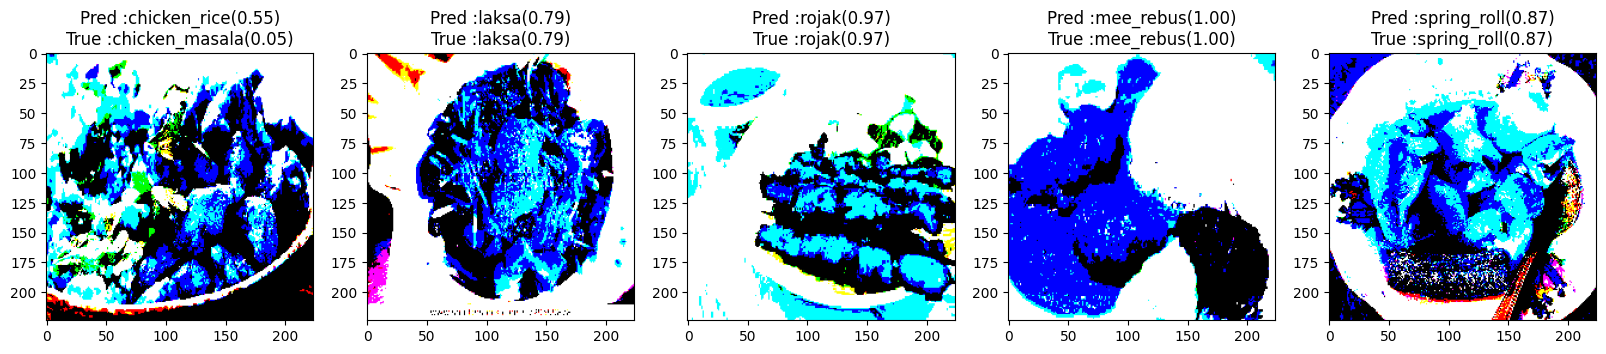

In [ ]:
classtolabel = {
    '0': 'char_kway_teow',
    '1': 'chicken_masala',
    '2': 'goreng_pisang',
    '3': 'hokkien_prawn_mee',
    '4': 'chicken_rice',
    '5': 'char_siew_rice',
    '6': 'chai_tow_kway',
    '7': 'kway_chap',
    '8': 'curry_puff',
    '9': 'ban_mian',
    '10': 'satay',
    '11': 'spring_roll',
    '12': 'roti_prata',
    '13': 'mee_rebus',
    '14': 'laksa',
    '15': 'siew_mai',
    '16': 'lotong_w_sayur_lodeh',
    '17': 'rojak',
    '18': 'roti_john',
    '19': 'nasi_lemak'
}
# Printing 5 random images from our test_generator together with their predicted and true labels
ind = np.random.randint(1,len(x_test),5)
fig, axis =plt.subplots(1,5,figsize=(20,10))
for i,j in enumerate(ind):
    axis[i].imshow(x_test[j])
    axis[i].set_title("Pred :{}({:.2f})\nTrue :{}({:.2f})".format
                          (classtolabel[str(y_pred[j])],np.max(y_pred_conf[j]),
                           classtolabel[str(y_true[j])],y_pred_conf[j][(y_true[j])],fontweight="bold", size=20))

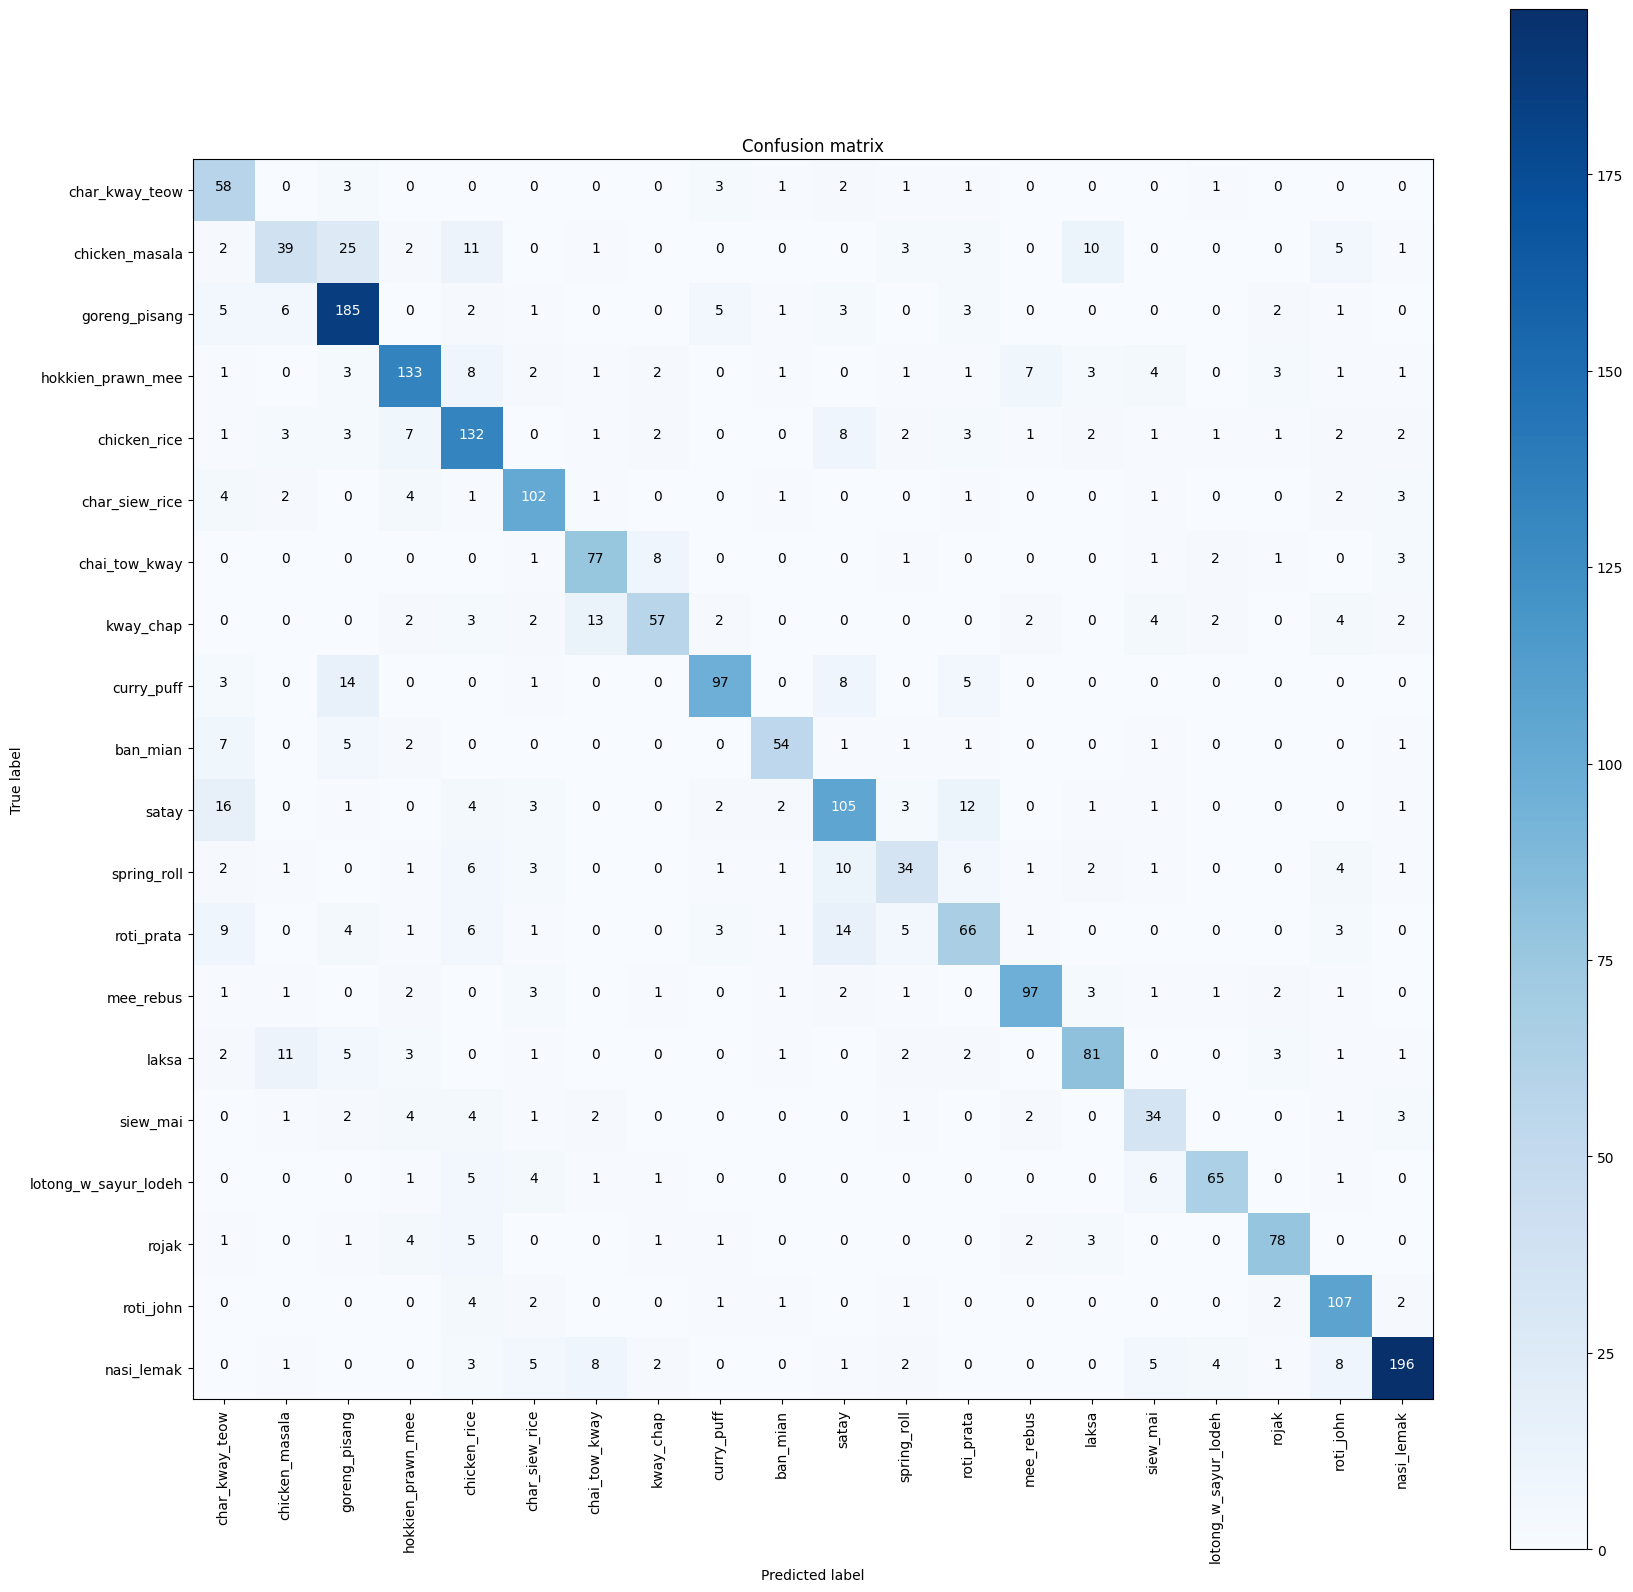

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    classes = ['char_kway_teow',
 'chicken_masala',
 'goreng_pisang',
 'hokkien_prawn_mee',
 'chicken_rice',
 'char_siew_rice',
 'chai_tow_kway',
 'kway_chap',
 'curry_puff',
 'ban_mian',
 'satay',
 'spring_roll',
 'roti_prata',
 'mee_rebus',
 'laksa',
 'siew_mai',
 'lotong_w_sayur_lodeh',
 'rojak',
 'roti_john',
 'nasi_lemak']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


classes = ['char_kway_teow',
 'chicken_masala',
 'goreng_pisang',
 'hokkien_prawn_mee',
 'chicken_rice',
 'char_siew_rice',
 'chai_tow_kway',
 'kway_chap',
 'curry_puff',
 'ban_mian',
 'satay',
 'spring_roll',
 'roti_prata',
 'mee_rebus',
 'laksa',
 'siew_mai',
 'lotong_w_sayur_lodeh',
 'rojak',
 'roti_john',
 'nasi_lemak']

plt.figure(figsize=(20, 20))
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=classes, title='Confusion matrix')